<a href="https://colab.research.google.com/github/djsabelo/BiosignalsDeepLearningWorkshop/blob/main/BiosignalSynthesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Let's create our sythesis model!

## Each step will guide you through this process:
### 1. Load data and set the first parameters
### 2. Make the input and the output matrices
### 3. Separate data for cross validation
### 4. Setup model and model's parameters
### 5. Setup training and optimizer's parameters
### 6. Train and check the output
### 7. Fine-tune variables



# 1. Load data and set the first parameters

First we have to import data from github from the previous workshop session. (no editing needed)

In [2]:
!git clone https://github.com/djsabelo/BiosignalsDeepLearningWorkshop.git

fatal: destination path 'BiosignalsDeepLearningWorkshop' already exists and is not an empty directory.


Now we have to load data from the file "segments.npz" and extract their contents.

In [3]:
import numpy as np
import matplotlib.pyplot as plt


# Find files in folder
folder = './BiosignalsDeepLearningWorkshop/data/'
filename = "segments.npz"

# Define sampling frequency
fs = 250

data = np.load(folder + filename)

for key in data.keys():
  print(key)


segments
window_size
overlap
quantization
decimate
smoothing


### 1. Get each parameter from the "data" dictionary and print the shape of the segments variable.

In [4]:
# Parameters
window_size = data["window_size"]
quantization = data["quantization"]
overlap = data["overlap"]

segments = data["segments"]
print(np.shape(segments))

#Expected Output:
#(5, 8997, 65)


(5, 8997, 65)


# 2. Make the input and the output matrices

As you may see, the 3-D matrix (or tensor) has 5 lines, one for each signal. 
We are going to synthesize **1** of these signals with the concept that the network will learn how to predict the next sample.
###2. Based on this premiss, how do we compute the output (y) from the input (x)?

In [5]:
x = segments[0,:,:-1]
y = segments[0,:,1:]


print(np.shape(x))
print(np.shape(y))

# Expected Output:
# (8997, 64)
# (8997, 64)

(8997, 64)
(8997, 64)


We are going to select the first 512 windows to make training faster. In a future setting, you may comment this code block

In [6]:
x = x[:512]
y = y[:512]

print(np.shape(x))
print(np.shape(y))

# Expected Output:
# (512, 64)
# (512, 64)

(512, 64)
(512, 64)


The next code plots one random example. Check the output!

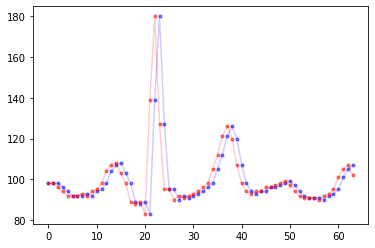

In [7]:
random_index = np.random.randint(len(segments))

plt.plot(x[random_index, :64], 'b.', alpha=0.5)
plt.plot(x[random_index, :64], 'b', alpha=0.2)
plt.plot(y[random_index, :64], 'r.', alpha=0.5)
plt.plot(y[random_index, :64], 'r', alpha=0.2)

# 3. Separate data for cross-validation
**Next we will have to ensure that our testing data is not present in our training data!**

Cross-validation is a way to see how our model perfoms with data that it did not see in training, to ensure that it will proceed

As a first approach we will separate the data into 70% for training and 30% for testing.

### 3. Separate data into training and testing sets, ensuring it does not overlap!

In [8]:
import math

# cross validation of first 70% for training data and last 30% of test data
last_train_index = int(0.7 * len(x))

x_train = x[:last_train_index]
y_train = y[:last_train_index]

first_test_index = int(last_train_index + math.ceil(window_size/overlap) + 1) # to ensure the test data does not overlap with train data

x_test = x[first_test_index:]
y_test = y[first_test_index:]

print("Number of rejected windows: {}".format(first_test_index - last_train_index))
print("Number of training windows: {}; Percentage: {} %".format(len(x_train), (len(x_train)*100/len(x))))
print("Number of testing windows: {}; Percentage: {} %".format(len(x_test), (len(x_test)*100/len(x))))


# Expected Output:
# Number of rejected data: 5
# Number of training windows: 6297; Percentage: 69.98999666555518 %
# Number of testing windows: 2689; Percentage: 29.887740357897076 %


Number of rejected windows: 5
Number of training windows: 358; Percentage: 69.921875 %
Number of testing windows: 149; Percentage: 29.1015625 %


# 4. Setup model and model's parameters

We are going to use the Keras library in the tensorflow framework.We are going to reproduce the following model:

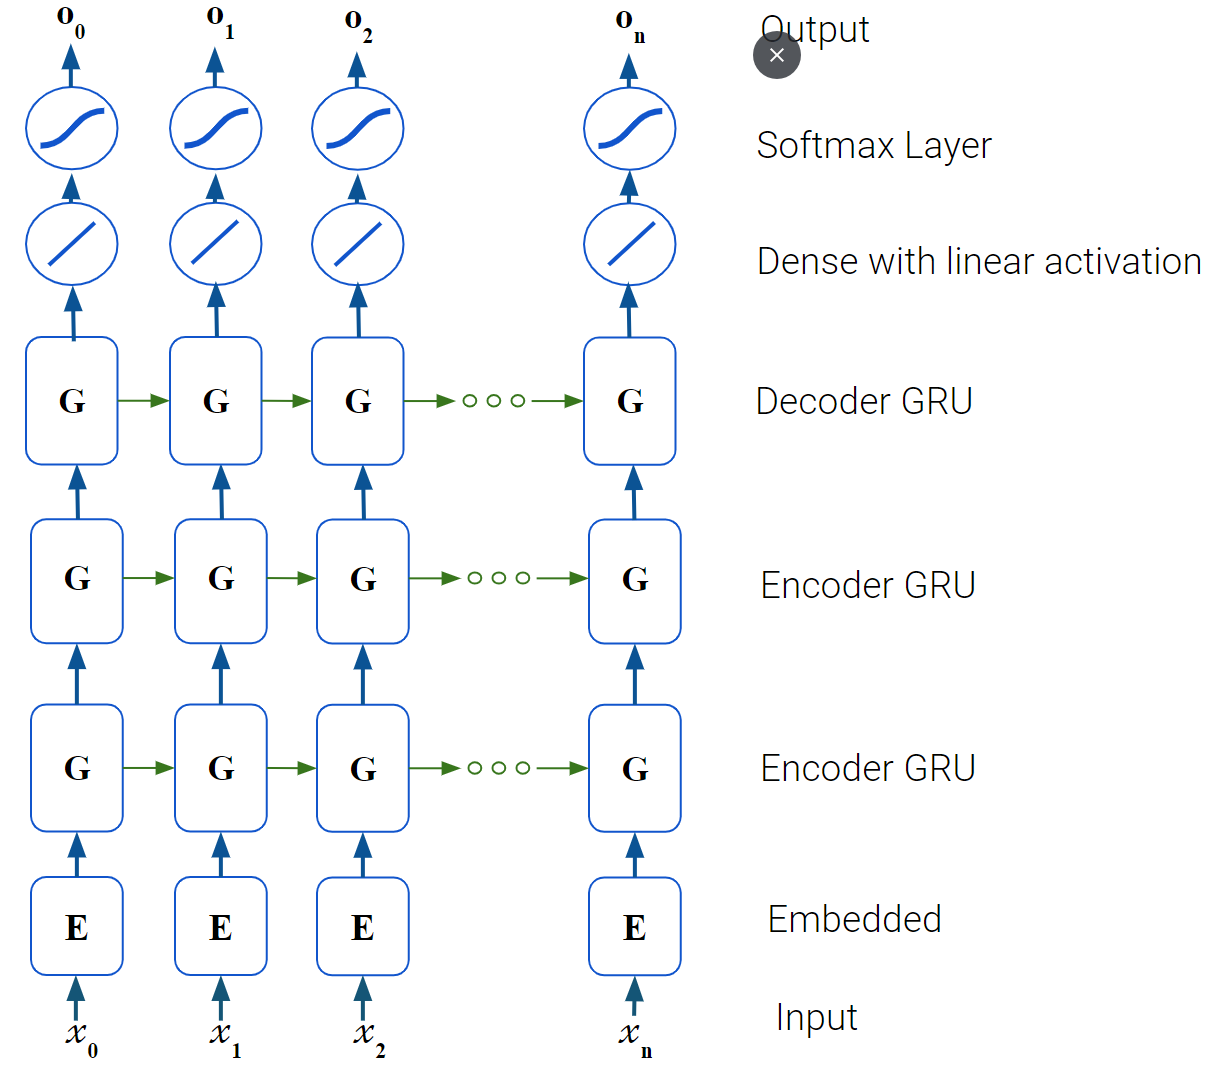


As we can see from this figure, the x represents each integer sample value of the ecg sequence. This value will choose one of the columns of the embedded matrix, which will also be trained, and fed into the first GRU layer. This layer will feed the next layer with its outputs. The following layers, the dense and softmax, will "classify" the corresponding sample of the ECG signal. Each output value is a vector representing the probabilities of each position being the next sample value. (one-hot-vector)

The following parameters are concerning this network:

- **encoder_hidden_neurons** - number of neurons the first two layers will have, this states the "memory" of the network - lower will decrease computational time, but fewer neurons do not produce satisfactory results;
- **decoder_hidden_neurons** - number of neurons the last GRU layer will have, this states the "memory" of the network  - lower will decrease computational time, but fewer neurons do not produce satisfactory results;
- **dense_layer_neurons** - number of layers the Dense layer will have, this will increase the complexity of the last layer to translate the inner states into the desired output - lower will decrease computational time, but fewer neurons do not produce satisfactory results;


### 4.1 pick a number between 32 and 2048 for each of the hidden_neurons parameters 
- remember the higher the value longer it takes to learn;

### 4.2 Fill out the missing "..." and ckeck out the outputs throughout the process. Remember to remove the "\#" comments with code;


In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

encoder_hidden_neurons = 256
decoder_hidden_neurons = 256
dense_layer_neurons = 512

print("Input layer:")

# Input layer - we usually have to reserve space in the GPU, 
# therefore we have to state a input layer
encoder_input = layers.Input(shape=(window_size,))  # the shape has to be of the size of the window_size in this case

# Embedded layer
encoder_embedded = layers.Embedding(
    input_dim=quantization,              # the input_dim must be the size of the number of possible values that the ECG may have
    output_dim=encoder_hidden_neurons)(  # the output_dim must be the size of the next layer input
    encoder_input                        # input of this layer, in this case it is the output of the last layer
)
print(encoder_input)
print("")

print("Embedded layer:")
print(encoder_embedded)
print("")

# Expected output
# Input layer:
# KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name='input_4'), name='input_4', description="created by layer 'input_4'")

# Embedded layer:
# KerasTensor(type_spec=TensorSpec(shape=(None, 64, 256), dtype=tf.float32, name=None), name='embedding_3/embedding_lookup/Identity_1:0', description="created by layer 'embedding_3'")


Input layer:
KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")

Embedded layer:
KerasTensor(type_spec=TensorSpec(shape=(None, 64, 256), dtype=tf.float32, name=None), name='embedding/embedding_lookup/Identity_1:0', description="created by layer 'embedding'")



In [10]:
# Fist GRU layer. Remember that we have the outputs and the inner states!

e_output, state_h = layers.GRU(encoder_hidden_neurons,  # the first argument is the number of neurons we want the network to have
                               return_state=True,       # return_states is a boolean parameter which ensures that the hidden state h is returned
                               return_sequences=True,   # return_sequences is a boolean parameter which ensures that all the states are returned instead of the last one 
                               name="encoder"           # name of the layer you want to discriminate
                               )(encoder_embedded)      # the input of this layer, in this case the output of the last layer
print("GRU layers:")
print("First layer:")
print(e_output)
print(state_h)
print("")

# GRU layers:
# First layer:
# KerasTensor(type_spec=TensorSpec(shape=(None, 64, 128), dtype=tf.float32, name=None), name='encoder/PartitionedCall:1', description="created by layer 'encoder'")
# KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='encoder/PartitionedCall:2', description="created by layer 'encoder'")


GRU layers:
First layer:
KerasTensor(type_spec=TensorSpec(shape=(None, 64, 256), dtype=tf.float32, name=None), name='encoder/PartitionedCall:1', description="created by layer 'encoder'")
KerasTensor(type_spec=TensorSpec(shape=(None, 256), dtype=tf.float32, name=None), name='encoder/PartitionedCall:2', description="created by layer 'encoder'")



In [11]:
print("Second layer:")
# Pass the state to a new GRU layer, as initial state
e_output, state_h  = layers.GRU(decoder_hidden_neurons, return_state=True, return_sequences=True, name="encoder_2")(
    e_output, initial_state=[state_h]
)
print(e_output)
print(state_h)
print("")

# Second layer:
# KerasTensor(type_spec=TensorSpec(shape=(None, 64, 128), dtype=tf.float32, name=None), name='encoder_2/PartitionedCall:1', description="created by layer 'encoder_2'")
# KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='encoder_2/PartitionedCall:2', description="created by layer 'encoder_2'")



Second layer:
KerasTensor(type_spec=TensorSpec(shape=(None, 64, 256), dtype=tf.float32, name=None), name='encoder_2/PartitionedCall:1', description="created by layer 'encoder_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 256), dtype=tf.float32, name=None), name='encoder_2/PartitionedCall:2', description="created by layer 'encoder_2'")



In [12]:
print("Third layer:")
# Pass the state to a new GRU layer, as initial state
decoder_output = layers.GRU(decoder_hidden_neurons, return_sequences=True, name="decoder")(
    e_output, initial_state=[state_h]
)
print(e_output)
print(state_h)
print("")

# Third layer:
# KerasTensor(type_spec=TensorSpec(shape=(None, 64, 128), dtype=tf.float32, name=None), name='encoder_2/PartitionedCall:1', description="created by layer 'encoder_2'")
# KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='encoder_2/PartitionedCall:2', description="created by layer 'encoder_2'")



Third layer:
KerasTensor(type_spec=TensorSpec(shape=(None, 64, 256), dtype=tf.float32, name=None), name='encoder_2/PartitionedCall:1', description="created by layer 'encoder_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 256), dtype=tf.float32, name=None), name='encoder_2/PartitionedCall:2', description="created by layer 'encoder_2'")



In [13]:
print("Latent layer:")
latent = layers.Dense(quantization)(decoder_output)
print(latent)
print("")

# Latent layer:
# KerasTensor(type_spec=TensorSpec(shape=(None, 64, 1000), dtype=tf.float32, name=None), name='dense_5/BiasAdd:0', description="created by layer 'dense_5'")


Latent layer:
KerasTensor(type_spec=TensorSpec(shape=(None, 64, 1000), dtype=tf.float32, name=None), name='dense/BiasAdd:0', description="created by layer 'dense'")



In [14]:
print("Softmax layer:")
probs = layers.Softmax()(latent)
print(probs)
print("")

print("Output layer:")
output = tf.math.argmax(
    probs, axis=2, output_type=tf.dtypes.int64, name="output"
)
print(output)

# Softmax layer:
# KerasTensor(type_spec=TensorSpec(shape=(None, 64, 1000), dtype=tf.float32, name=None), name='softmax_5/Softmax:0', description="created by layer 'softmax_5'")
#
# Output layer:
# KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.int64, name=None), name='tf.math.argmax_5/ArgMax:0', description="created by layer 'tf.math.argmax_5'")


Softmax layer:
KerasTensor(type_spec=TensorSpec(shape=(None, 64, 1000), dtype=tf.float32, name=None), name='softmax/Softmax:0', description="created by layer 'softmax'")

Output layer:
KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.int64, name=None), name='tf.math.argmax/ArgMax:0', description="created by layer 'tf.math.argmax'")


This lines of code just build the model using the input 

In [15]:
model = keras.Model(encoder_input, probs)
model.summary()

model.load_weights("ecg_synthesis_checkpoint")

# Expected output
# Model: "model"
# __________________________________________________________________________________________________
# Layer (type)                    Output Shape         Param #     Connected to                     
# ==================================================================================================
# input_11 (InputLayer)           [(None, 64)]         0                                            
# __________________________________________________________________________________________________
# embedding_2 (Embedding)         (None, 64, 128)      128000      input_11[0][0]                   
# __________________________________________________________________________________________________
# encoder (GRU)                   [(None, 64, 128), (N 99072       embedding_2[0][0]                
# __________________________________________________________________________________________________
# encoder_2 (GRU)                 [(None, 64, 128), (N 99072       encoder[0][0]                    
#                                                                  encoder[0][1]                    
# __________________________________________________________________________________________________
# decoder (GRU)                   (None, 64, 128)      99072       encoder_2[0][0]                  
#                                                                  encoder_2[0][1]                  
# __________________________________________________________________________________________________
# dense (Dense)                   (None, 64, 1000)     129000      decoder[0][0]                    
# __________________________________________________________________________________________________
# softmax (Softmax)               (None, 64, 1000)     0           dense[0][0]                      
# ==================================================================================================
# Total params: 554,216
# Trainable params: 554,216
# Non-trainable params: 0

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 64, 256)      256000      input_1[0][0]                    
__________________________________________________________________________________________________
encoder (GRU)                   [(None, 64, 256), (N 394752      embedding[0][0]                  
__________________________________________________________________________________________________
encoder_2 (GRU)                 [(None, 64, 256), (N 394752      encoder[0][0]                    
                                                                 encoder[0][1]                

This will help to visualize data durring our training, Do not concern with this!

In [16]:
class show_intermediate_outputs(tf.keras.callbacks.Callback):
    """
    Callback class for Keras to run prediction on a model
    It will save the results of the model to a file after plotting
    """

    def __init__(self, model, x_example):
        """
        `input_names` should be a list of graph names
        """
      
        self.model = model
        self.x_example = x_example
        self.predicts = [np.argmax(self.model.predict(self.x_example), axis=2)]
    
    def on_batch_end(self, batch, logs=None):              
        self.predicts.append(np.argmax(self.model.predict(self.x_example), axis=2))

    #def on_epoch_end(self, batch, logs=None):              
    #    self.predicts.append(np.argmax(self.model.predict(self.x_example), axis=2))

class save_losses(tf.keras.callbacks.Callback): 
    """
    Save the losses, mse, and accuracy of a model to a file in the intermediates folder
    """
    def __init__(self, model_name):
        # Make sure the test model save path exists
        if not os.path.exists("intermediates/"):
            os.mkdir("intermediates/")
        self.model_name = model_name

        self.metric_file = "intermediates/metrics.txt"

    def on_train_begin(self, logs={}):
        self.losses = []
        self.mses = []
        self.acc = []

    # Save to a file when the training ends
    def on_train_end(self, logs={}):
        np.savetxt(self.metric_file, self.losses)

    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
 

# 5. Setup training and optimizer's parameters


- **lr** - this will change the optimization process of the network
batch_size - the higher the size the training is faster, but the quality of the results may decrease. The lower the size, the higher probability for the data to overfit.

In [17]:
lr = 0.001

model.compile(tf.keras.optimizers.RMSprop(learning_rate=lr), 
              "mse", 
              metrics=[tf.metrics.Precision(), tf.metrics.Recall()])

# Train and check the output

In [18]:
import os 

checkpoint_path = "/training/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
save_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,   
                                                 save_freq= 1000*10)
predict_callback = show_intermediate_outputs(model, x_train[random_index])
loss_history_callback = save_losses("ECG_synthesis")


In [19]:
epochs = 100
batch_size = 32


model.fit(x_train, 
          np.identity(quantization)[y_train], 
          callbacks=[loss_history_callback, save_callback, predict_callback], 
          epochs=epochs, 
          batch_size=batch_size, 
          shuffle=True)

model.save_weights("ecg_synthesis_checkpoint")
model.evaluate(x_test, np.identity(quantization)[y_test], verbose=1)



Epoch 1/10
12/12 [==============================] - 17s 916ms/step - loss: 1.2441e-05 - precision: 0.9995 - recall: 0.9881
Epoch 2/10
12/12 [==============================] - 10s 854ms/step - loss: 1.2946e-05 - precision: 0.9997 - recall: 0.9874
Epoch 3/10
12/12 [==============================] - 10s 807ms/step - loss: 1.3602e-05 - precision: 0.9994 - recall: 0.9870
Epoch 4/10
12/12 [==============================] - 11s 967ms/step - loss: 1.2250e-05 - precision: 0.9995 - recall: 0.9883
Epoch 5/10
12/12 [==============================] - 11s 884ms/step - loss: 1.3764e-05 - precision: 0.9994 - recall: 0.9868
Epoch 6/10
12/12 [==============================] - 11s 916ms/step - loss: 1.3825e-05 - precision: 0.9994 - recall: 0.9867
Epoch 7/10
12/12 [==============================] - 11s 912ms/step - loss: 1.2420e-05 - precision: 0.9995 - recall: 0.9882
Epoch 8/10
12/12 [==============================] - 10s 806ms/step - loss: 1.2758e-05 - precision: 0.9996 - recall: 0.9878
Epoch 9/10
12/12

[0.0010534202447161078, 0.3791394829750061, 0.3289639353752136]

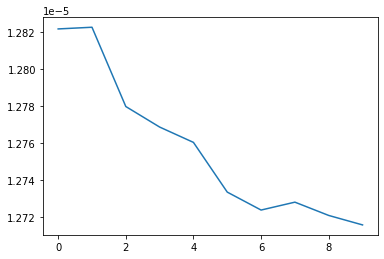

In [20]:
plt.plot(loss_history_callback.losses)

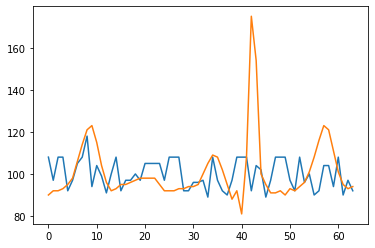

In [21]:

random_record = np.random.randint(len(x_train))
plt.plot(np.argmax(model.predict(x_train[random_record]), axis=2))
plt.plot(y_train[random_record])

R^2: 0.947930397842041


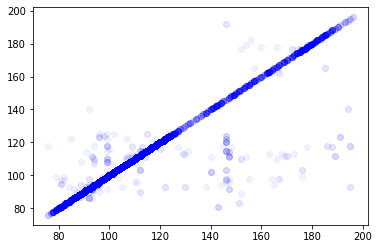

In [22]:
from sklearn.metrics import r2_score

train_predictions = np.argmax(model.predict(x_train), axis=2)
plt.scatter(train_predictions, y_train, alpha=0.05, color="blue")
print("R^2: {}".format(r2_score(y_train, train_predictions)))

R^2: 0.6586454523751986


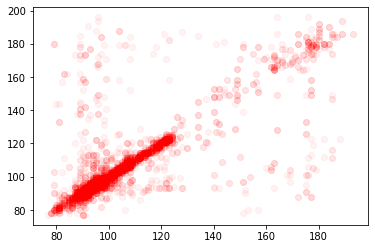

In [23]:
test_predictions = np.argmax(model.predict(x_test), axis=2)
plt.scatter(test_predictions, y_test, alpha=0.05, color="red")
print("R^2: {}".format(r2_score(y_test, test_predictions)))

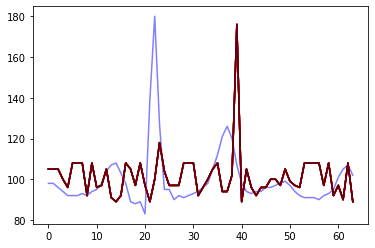

In [24]:

from matplotlib import cm
reds = cm.get_cmap('Reds', 12)

plt.plot(y_train[random_index], "b", alpha=0.5)
for i, prediction in enumerate(predict_callback.predicts[0:-1:10]):
  plt.plot(prediction, alpha=1, color=reds((i+1)/len(predict_callback.predicts[0:-1:10])))

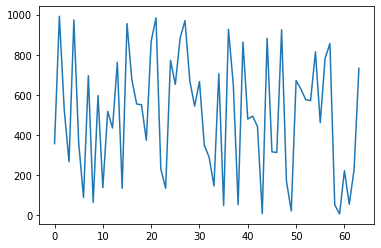

In [44]:
synthesized_signal = np.random.randint(0, quantization, (1, window_size))
plt.plot(synthesized_signal.T)


# 7. Fine-tune variables

#8. Let's synthesize!!!!!!

Synthesizing:
.0
..........10..........20..........30..........40..........50..........60..........70..........80..........90..........100
..........110..........120..........130..........140..........150..........160..........170..........180..........190..........200
..........210..........220..........230..........240..........250.....
(320,)


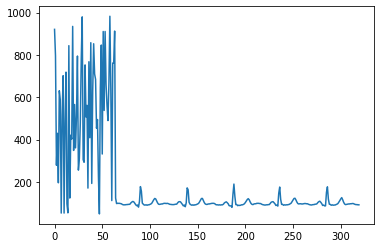

In [53]:
N = 256
synthesized_signal = np.random.randint(0, quantization, window_size)
print("Synthesizing:")
for i in range(N):
  input = np.expand_dims(synthesized_signal[-window_size:], axis=0)

  output = np.argmax(model.predict(input), axis=2).T
  next_sample = output[-1]

  synthesized_signal = np.concatenate([synthesized_signal, next_sample])
  print(".", end="")
  if i % 10 == 0:
    print(i, end="")
  if i % 100 == 0:
    print("")

print("")
print(np.shape(synthesized_signal))
plt.plot(synthesized_signal)

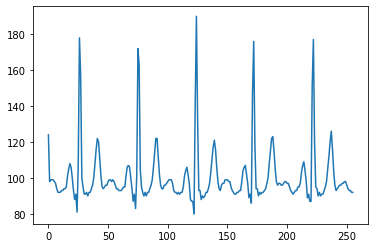

In [56]:
plt.plot(synthesized_signal[window_size:])